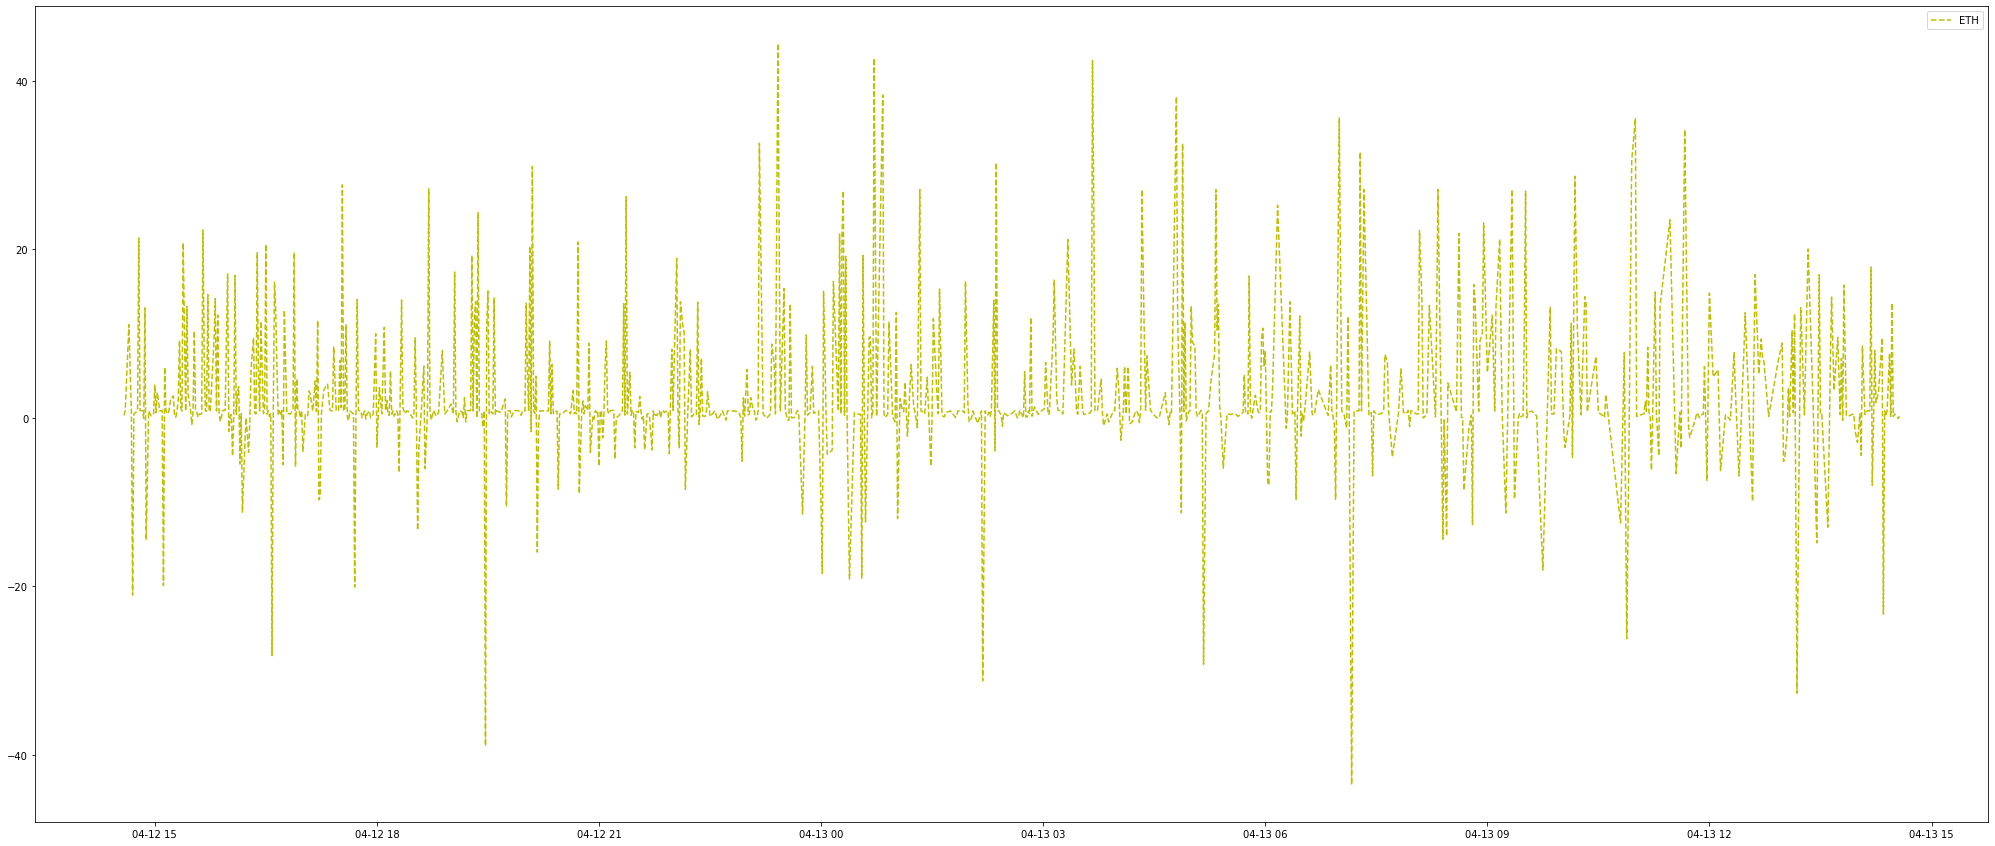

In [11]:
import sys; sys.path.append('../')  # for correct types inclusion

import datetime
import time

import grpc

import types_pb2
import types_pb2_grpc
from google.protobuf import timestamp_pb2
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

SERVER_ADDRESS = 'apiv1.cryptomood.com:443'
PATH_TO_CERT_FILE = './cert.pem'


def datetime_from_candle(val):
    return datetime.datetime(year=val.id.year, month=val.id.month, day=val.id.day,
                             hour=val.id.hour, minute=val.id.minute)


def create_sentiment_historic_request(timestamp_from, timestamp_to, resolution, asset):
    # in our case we have to use kwarg because `from` is
    # is recognized as python keyword so there would syntax be error
    # if you want get value you have to use getattr()
    sentiment_historic_request_kwargs = {
        'from': timestamp_from,
        'to': timestamp_to,
        'resolution': resolution,
        'asset': asset
    }
    return types_pb2.SentimentHistoricRequest(**sentiment_historic_request_kwargs)


def plot_sentiments(candles_wrapper):
    line_types = ['r-', 'g-', 'b-', 'y-', 'r--', 'g--', 'b--', 'y--']
    legends = []
    if len(candles_wrapper) > len(line_types):
        # add more line types
        exit(1)

    for candles in candles_wrapper:
        if len(candles) == 0:
            continue
        asset = candles[0].asset

        # sort candles by start_time
        candles = sorted(candles, key=lambda val: datetime_from_candle(val))

        # create lists of  datetime from google.protobuf.Timestamp
        x = [datetime_from_candle(candle) for candle in candles]

        # create lists of average sentiment values
        y = [x.a for x in candles]

        # plot graph
        plt.figure(figsize=(35,15))
        plt.plot(x, y, line_types.pop(), label=asset)
        legends.append(asset)
        


    plt.gca().legend(legends)
    plt.show()


def get_historic_socials_sentiment(channel, requests):
    # create stub
    stub = types_pb2_grpc.SentimentsStub(channel=channel)

    candle_wrapper = []

    for i, req in enumerate(requests):
        candle_wrapper.append([])
        candle_stream = stub.HistoricSocialSentiment(req)
        for candle in candle_stream:
            candle_wrapper[i].append(candle)

    return candle_wrapper


def main():
    # Create credentials for use with an secured channel
    credentials = grpc.ssl_channel_credentials(open(PATH_TO_CERT_FILE, 'rb').read())

    # uncomment commands below if token auth is required
    call_credentials = grpc.access_token_call_credentials('ed737d23e01bb1dea60e7e0c16cf3b8a')
    credentials = grpc.composite_channel_credentials(credentials, call_credentials)

    channel = grpc.secure_channel(SERVER_ADDRESS, credentials)

    # create interval
    # in our case < 2 days ago, now >
    now = time.time()
    seconds = int(now)
    to_timestamp = timestamp_pb2.Timestamp(seconds=seconds)
    from_timestamp = timestamp_pb2.Timestamp(seconds=to_timestamp.seconds - (86400 * 1))  # two days ago

    # set resolution of candles
    resolution = 'M1'

    # pick assets from documentation
    assets = ['ETH']

    # create requests

    # list of SentimentHistoricRequest
    requests = []
    for asset in assets:
        req = create_sentiment_historic_request(timestamp_from=from_timestamp, timestamp_to=to_timestamp,
                                                resolution=resolution, asset=asset)
        requests.append(req)

    # [[asset1_candles], [asset2_candles]]
    candles_wrapper = get_historic_socials_sentiment(channel=channel, requests=requests)
    plot_sentiments(candles_wrapper)


if __name__ == '__main__':
    main()
